In [1]:
import sys
from pathlib import Path

notebook_dir = Path().resolve()
target_path = notebook_dir.parent.parent / 'ml-xai'
sys.path.append(str(target_path))


from WISP.WISP import *

# Crippen logP

In [2]:
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Crippen

In [3]:
data_Crippen = pd.read_csv('/Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/Crippen-MolNet/Lipophilicity-Crippen.csv')

In [4]:
Smiles_Column_Name = "smiles"
Target_Column_Name = 'crippen_logP'
ID_Column_Name = 'CMPD_CHEMBLID'
working_dir = '/Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/pure-Crippen/'
task_type = 'regression'

### Preprocess

In [ ]:
data_Crippen.rename(columns={ID_Column_Name: 'ID'}, inplace=True)

std = Standardizer(max_num_atoms=1000,
                max_num_tautomers=10,
                include_stereoinfo=False,
                keep_largest_fragment=True, 
                canonicalize_tautomers=True, 
                normalize=True, 
                sanitize_mol=True)
data_Crippen["smiles_std"] = data_Crippen[Smiles_Column_Name].apply(lambda smi: std(smi)[0]) 
data_Crippen = filter_duplicates(data_Crippen, 'smiles_std', Target_Column_Name)

#save data in smi format
data_Crippen[['smiles_std', 'ID', Target_Column_Name]].to_csv(working_dir + "data.smi", sep='\t', index=False, header=False)

### Create MMP database

In [6]:
columns_to_keep = [Target_Column_Name]
data_MMPs = create_MMP_database(working_dir + "data.smi", working_dir ,data_Crippen, columns_to_keep)

/Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/ml-xai/WISP/create_MMPs.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_MMPs_filtered[i + '_1'] = data_MMPs_filtered['ID_1'].map(data_to_add_information_from.set_index('ID')[i])
/Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/ml-xai/WISP/create_MMPs.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_MMPs_filtered[i + '_2'] = data_MMPs_filtered['ID_2'].map(data_to_add_information_from.set_index('ID')[i])


### Add Hydrogens

In [ ]:
def get_smiles(row, ed_or_pro):
    transformation = row['transformation']
    prod = transformation.split(">>")[ed_or_pro]
    mol_prod = Chem.MolFromSmiles(prod)
    mol_prod = Chem.AddHs(mol_prod)
    
    constant = row['constant']
    mol_constant = Chem.MolFromSmiles(constant)
    
    combo = Chem.CombineMols(mol_prod, mol_constant)
    
    dummy_atoms = [atom.GetIdx() for atom in combo.GetAtoms() if atom.GetAtomicNum() == 0]

    neighbors = [list(combo.GetAtomWithIdx(idx).GetNeighbors())[0].GetIdx() for idx in dummy_atoms]

    editable = Chem.EditableMol(combo)
    editable.AddBond(neighbors[0], neighbors[1], order=Chem.BondType.SINGLE)
    
    for idx in sorted(dummy_atoms, reverse=True):
        editable.RemoveAtom(idx)
    
    mol = editable.GetMol()
    Chem.SanitizeMol(mol)
    return Chem.MolToSmiles(mol)

data_MMPs['smiles_2'] = data_MMPs.apply(get_smiles, axis=1, args=(1,))
data_MMPs['smiles_1'] = data_MMPs.apply(get_smiles, axis=1, args=(0,))

### Get the contributions directly from Crippen

In [ ]:
def RDKit_normalized_weights(smiles):
    mol = Chem.MolFromSmiles(smiles, sanitize=False)
    Chem.SanitizeMol(mol)#to parse explicit hydrogen
    
    contribs = rdMolDescriptors._CalcCrippenContribs(mol)
    contribs = [x[0] for x in contribs]
    return contribs

In [9]:
data_MMPs["Contributions Crippen_1"] = data_MMPs["smiles_1"].apply(RDKit_normalized_weights)
data_MMPs["Contributions Crippen_2"] = data_MMPs["smiles_2"].apply(RDKit_normalized_weights)

### Add Crippen logP

In [11]:
def calculate_logp(smiles):
    mol = Chem.MolFromSmiles(smiles, sanitize=False)
    Chem.SanitizeMol(mol)
    if mol:
        return Crippen.MolLogP(mol)
    return None

data_MMPs['predictions_1'] = data_MMPs["smiles_1"].apply(calculate_logp)
data_MMPs['predictions_2'] = data_MMPs["smiles_2"].apply(calculate_logp)

### Get Indices of the Variable Part

In [12]:
data_MMPs[["unmatched_atom_index_1", "unmatched_atom_index_2"]] = data_MMPs.apply(
lambda row: pd.Series(get_unmatched_atom_indices_fragments(row["smiles_1"], row["smiles_2"], row["constant"])), axis=1)

### Add Plots

In [17]:
def analyze_locality(data_MMPs, working_dir):
    data_MMPs['unmatched_atom_index_1_with_neighbors'] = data_MMPs.apply(lambda row: get_neighbors(row['smiles_1'], row['unmatched_atom_index_1']), axis=1)
    data_MMPs['unmatched_atom_index_2_with_neighbors'] = data_MMPs.apply(lambda row: get_neighbors(row['smiles_2'], row['unmatched_atom_index_2']), axis=1)

    methods = {
    'Crippen': ('Contributions Crippen_1', 'Contributions Crippen_2', '#82d8a1', 'CRIPPEN')}

    for method, (attr1, attr2, color, label) in methods.items():
        key1 = f'summ_unmatched_{method}_contributions_1_sphere'
        key2 = f'summ_unmatched_{method}_contributions_2_sphere'
        delta_key = f'delta_sum_fragment_{method}_contributions_sphere'

        data_MMPs[key1] = get_unmatched_attributions(data_MMPs, attr1, 'unmatched_atom_index_1_with_neighbors')
        data_MMPs[key2] = get_unmatched_attributions(data_MMPs, attr2, 'unmatched_atom_index_2_with_neighbors')
        data_MMPs[delta_key] = data_MMPs[key1] - data_MMPs[key2]

        r2 = np.corrcoef(data_MMPs['delta_prediction'], data_MMPs[delta_key])[0,1]**2

        plot_2D(
            [f'$r^2$({method}) = {r2:.2f}'], 'upper left',
            data_MMPs['delta_prediction'],
            data_MMPs[delta_key],
            '$\Delta$Predictions MMP',
            '$\Delta$Attributions MMP (Fragment+Neig)',
            working_dir + label + 'attributor_NEIG.png',
            color,
            include_line=False,
            line_style='None'
        )
    return data_MMPs

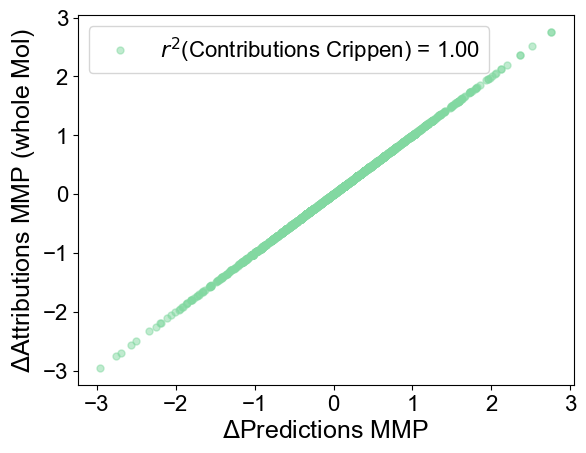

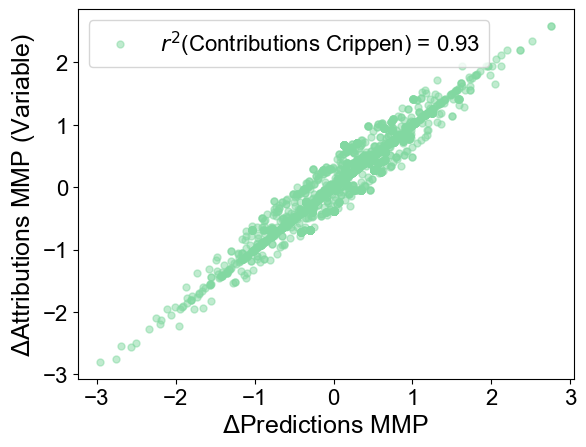

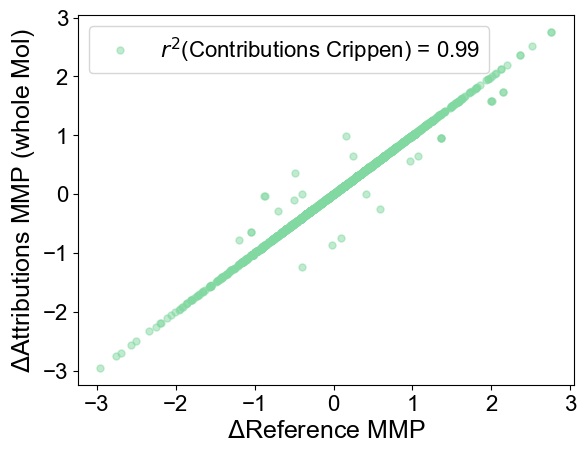

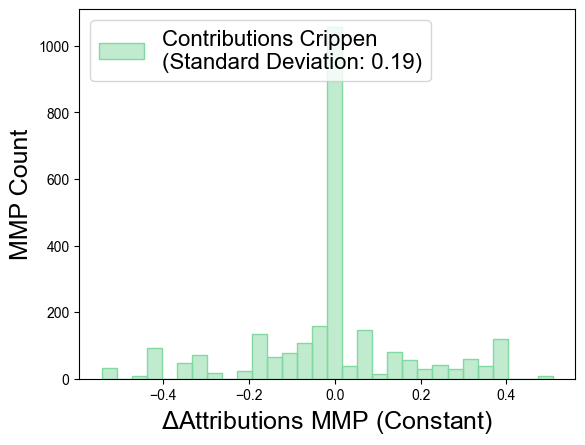

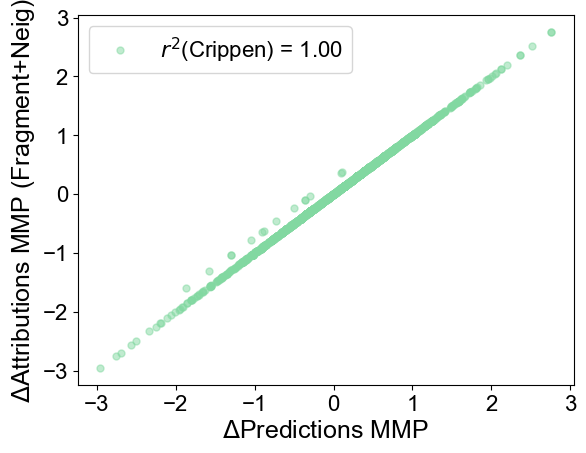

In [18]:
Attribution_Columns = ['Contributions Crippen']
color_coding =['#82d8a1']
for attr_method, color in zip(Attribution_Columns, color_coding): 
    data_MMPs = plot_MMP_correlations(data_MMPs, attr_method, color, working_dir, Target_Column_Name)
    data_MMPs = plot_const_histogram(data_MMPs, attr_method, color, working_dir)
data_MMPs = analyze_locality(data_MMPs, working_dir)

### Calculate Heatmaps

In [16]:
Attribution_Columns = ["Contributions Crippen_1"]

directory = working_dir + "HeatMaps"
if not os.path.exists(directory):
    os.makedirs(directory)

for index, row in data_MMPs.iterrows():
    for attr_method in Attribution_Columns:
        output_dir = directory + '/'
    generate_heatmap(data_MMPs, index, output_dir, 'smiles_1', attr_method, 'ID_1', task_type)

KeyboardInterrupt: 

In [ ]:
Attribution_Columns = ["Contributions Crippen_2"]

directory = working_dir + "HeatMaps"
if not os.path.exists(directory):
    os.makedirs(directory)

for index, row in data_MMPs.iterrows():
    for attr_method in Attribution_Columns:
        output_dir = directory + '/'
    generate_heatmap(data_MMPs, index, output_dir, 'smiles_2', attr_method, 'ID_2', task_type)

#### For a Single Molecule (CHEMBL2086684)

In [17]:
vmin = -0.8186
vmax = 0.8186

smiles = '[H]C([H])([H])C1CN(C(=O)OC(C)(C)C)CCN1c1ncc(OCc2ccncc2C#N)cn1'
attributions = [0.123, 0.1441, 0.123, 0.123, -0.2051, -0.2035, -0.3187, -0.2783, 0.4833, -0.0684, -0.2051, 0.1441, 0.1441, 0.1441, -0.2035, -0.2035, -0.4458, 0.4619, -0.3239, 0.1581, 0.5437, -0.4195, -0.0516, 0.136, 0.1581, 0.1581, -0.3239, 0.1581, 0.136, 0.0017, 0.01508, 0.1581, -0.3239]


mol = Chem.MolFromSmiles(smiles, sanitize=False)
Chem.SanitizeMol(mol)#to keep the explicit hydrogens

draw2d = Draw.MolDraw2DCairo(900, 900)
d = GetSimilarityMapFromWeightsWithScale(mol, attributions, draw2d, '#10384f', '#9C0D38', vmin, vmax)
d.FinishDrawing()

# Define and write output path
filename = f"CHEMBL2086684_Crippen.png"
output_path = os.path.join(output_dir, filename)
with open(output_path, "wb") as f:
    f.write(d.GetDrawingText())

In [ ]:
data_MMPs.to_csv(working_dir + "Complete_Data.csv", index=False)